### Module XGBoost

Dans ce module, on va comprendre l'algorithme Xgboost:

Rappelons l'algorithme Gradient Boosting:

*Input :*
- $D((x_i , y_i) i = 1,\dots, n)$
- Nombre d'arbres (M)

1) Trouver la constante $f_0 (x)  = \gamma$ tq  $argmin_\gamma = \sum_{i = 1}^{n} l(y_i, l)$

for t = 1 To M :

a) Calculer le pseudo résidus $r_im = - \frac{\partial l(y_i, f(x_i)}{\partial f}|_{f = f_{t-1}}$

b) Entrainer un weak learn $(h_t)$ qui va nous permettre de trouver nos régions (R_j)_{1,\dots, J}

c) Trouver les valeurs sur nos feuilles en optimisant $argmin_{ w_j} \sum_{i = 1}^{n} l(y_i, f_{t-1} + \sum_{j = 1}^{J} w_j I(x_i \in R_j))$

d) $f_t(x_i) = f_{t-1}(x_i) + \eta w_j I(x_i \in R_j)$


L'algorithme est un peu du Gradient Boosting en proposant d'un arbre de regression propre à lui même qui prendre en compte des paramètre de régularisation.

En XGBoost, on optimise une fonction objectif ayant deux composantes:

- la fonction de perte $l(y_i, \hat{y_i})$
- la fonction de régularisation $\gamma T + \lambda \sum_{j = 1}^{T} wj^2$

La solution $w_j$ de ces arbres et l'évaluation de la fonction objectif sont :
$$\begin{split}w_j^\ast &= -\frac{G_j}{H_j+\lambda}\\
\text{obj}^\ast &= -\frac{1}{2} \sum_{j=1}^T \frac{G_j^2}{H_j+\lambda} + \gamma T\end{split}$$

Avec $G_j = \sum_{i\in I_j} g_i$ et $H_j = \sum_{i\in I_j} h_i$ et 
$\begin{split}g_i &= \partial_{\hat{y}_i^{(t-1)}} l(y_i, \hat{y}_i^{(t-1)})\\
h_i &= \partial_{\hat{y}_i^{(t-1)}}^2 l(y_i, \hat{y}_i^{(t-1)})\end{split}$ le gradient et la hessienne de notre fonction de perte.

Avec une fonction de perte quatratique $l(yi, \hat{y_i}) = (y_i - \hat{y_i})^2$, 

$w_j$ et $obj$ s'intèprète comme suite: $$w_j = \frac{\text{somme des résidus}}{\text{nombre de résidus} + \lambda}\\
obj = - 0.5 * \frac{\text{somme des résidus carré}}{\text{nombre de résidus} + \lambda} + \gamma T $$

On définit le gain comme:

$$Gain = \frac{1}{2} \left[\frac{G_L^2}{H_L+\lambda}+\frac{G_R^2}{H_R+\lambda}-\frac{(G_L+G_R)^2}{H_L+H_R+\lambda}\right] - \gamma \\
Gain = 0.5 * (Obj_{\text{feuille gauche}}  +  Obj_{\text{feuille droite}} -  Obj_{\text{noeud initial}}) - \gamma $$
Donc les arbres de regression se bâtissent comme suit:

- On cherche la variable et le seuil qui offrira un gain maximal

Comprendre les hyperparamètres généraux de XGBoost:

- $\eta$ est la vitesse d'apprentissage, contôle vitesse à laquelle notre algorithme. Un plus petit eta aura besoin de plus d'arbres pour converger et vice versa. Mais une grande valeur de eta peut faire qu'on n'atteint pas le minimum local.


- $\gamma$ pénalise le nombre de feuilles de nos arbres de régression. Contôle la complexité de notre arbreé


- $\alpha$ (pénalité norme l2) pénalise la valeur de sortie de nos arbres pour éviter le surajustement. Elle doit être controler pour offrir une bonne généralisation sur l'ensemble de validation.


La documentation de XGBoost se trouve sur $\href{https://xgboost.readthedocs.io/en/stable/tutorials/model.html}{ici}$

### Importation des libraries

In [280]:
import xgboost as xgb
import pandas as pd
from sklearn.metrics import roc_curve
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

### Chargement de la base de données:

In [197]:
df = pd.read_csv("C:/Users/mauac/Desktop/ACT6100/insurance_claims.csv")

In [198]:
df.head()

months_as_customer  age  policy_number policy_bind_date policy_state  \
0                 328   48         521585       2014-10-17           OH   
1                 228   42         342868       2006-06-27           IN   
2                 134   29         687698       2000-09-06           OH   
3                 256   41         227811       1990-05-25           IL   
4                 228   44         367455       2014-06-06           IL   

  policy_csl  policy_deductable  policy_annual_premium  umbrella_limit  \
0    250/500               1000                1406.91               0   
1    250/500               2000                1197.22         5000000   
2    100/300               2000                1413.14         5000000   
3    250/500               2000                1415.74         6000000   
4   500/1000               1000                1583.91         6000000   

   insured_zip  ... police_report_available total_claim_amount injury_claim  \
0       466132  ...                     YES              71610         6510   
1       468176  ...                       ?               5070          780   
2       430632  ...                      NO              34650         7700   
3       608117  ...                      NO              63400         6340   
4       610706  ...                      NO               6500         1300   

  property_claim vehicle_claim  auto_make  auto_model auto_year  \
0          13020         52080       Saab         92x      2004   
1            780          3510   Mercedes        E400      2007   
2           3850         23100      Dodge         RAM      2007   
3           6340         50720  Chevrolet       Tahoe      2014   
4            650          4550     Accura         RSX      2009   

  fraud_reported _c39  
0              Y  NaN  
1              Y  NaN  
2              N  NaN  
3              Y  NaN  
4              N  NaN  

[5 rows x 40 columns]

#### Objectif de modélisation:

Utiliser un modèle de boosting (XGBoost) pour prédire il y a fraude ou pas. Notre variable d'intèrêt est $\textbf{fraud_reported}$.

#### Nettoyage de notre base de données: 

In [199]:
df = df.drop(['_c39', 'policy_bind_date', 'policy_number', 'policy_csl'], axis= 1)

Je retirai la colonne policy_bind_date et _c39

In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_state                 1000 non-null   object 
 3   policy_deductable            1000 non-null   int64  
 4   policy_annual_premium        1000 non-null   float64
 5   umbrella_limit               1000 non-null   int64  
 6   insured_zip                  1000 non-null   int64  
 7   insured_sex                  1000 non-null   object 
 8   insured_education_level      1000 non-null   object 
 9   insured_occupation           1000 non-null   object 
 10  insured_hobbies              1000 non-null   object 
 11  insured_relationship         1000 non-null   object 
 12  capital-gains                1000 non-null   int64  
 13  capital-loss       

In [201]:
df.isna().sum(axis = 0)

months_as_customer             0
age                            0
policy_state                   0
policy_deductable              0
policy_annual_premium          0
umbrella_limit                 0
insured_zip                    0
insured_sex                    0
insured_education_level        0
insured_occupation             0
insured_hobbies                0
insured_relationship           0
capital-gains                  0
capital-loss                   0
incident_date                  0
incident_type                  0
collision_type                 0
incident_severity              0
authorities_contacted          0
incident_state                 0
incident_city                  0
incident_location              0
incident_hour_of_the_day       0
number_of_vehicles_involved    0
property_damage                0
bodily_injuries                0
witnesses                      0
police_report_available        0
total_claim_amount             0
injury_claim                   0
property_c

Apparemment, il n'y a pas de valeur manquantes, mais investissons les variables catégorielles qui peuvent contenir des caractères indésirables

In [202]:
categorical_columns =  df.select_dtypes(include = ['object']).columns

In [203]:
for col in categorical_columns:
    print(f"{col}: ---------------------------------- {df[col].unique()}")


policy_state: ---------------------------------- ['OH' 'IN' 'IL']
insured_sex: ---------------------------------- ['MALE' 'FEMALE']
insured_education_level: ---------------------------------- ['MD' 'PhD' 'Associate' 'Masters' 'High School' 'College' 'JD']
insured_occupation: ---------------------------------- ['craft-repair' 'machine-op-inspct' 'sales' 'armed-forces' 'tech-support'
 'prof-specialty' 'other-service' 'priv-house-serv' 'exec-managerial'
 'protective-serv' 'transport-moving' 'handlers-cleaners' 'adm-clerical'
 'farming-fishing']
insured_hobbies: ---------------------------------- ['sleeping' 'reading' 'board-games' 'bungie-jumping' 'base-jumping' 'golf'
 'camping' 'dancing' 'skydiving' 'movies' 'hiking' 'yachting' 'paintball'
 'chess' 'kayaking' 'polo' 'basketball' 'video-games' 'cross-fit'
 'exercise']
insured_relationship: ---------------------------------- ['husband' 'other-relative' 'own-child' 'unmarried' 'wife' 'not-in-family']
incident_date: ------------------------

On voit que les $\textbf{collision_type, property_damage, police_report_available}$ ont des "?" indésirable. On va voit la proportion qu'il représente dans notre base de données.

In [204]:
for col in ["collision_type", "property_damage", "police_report_available"]:
    print(f"{col}:------------------------------------{(sum(df[col]== '?') / df.shape[0]) * 100} ")

collision_type:------------------------------------17.8 
property_damage:------------------------------------36.0 
police_report_available:------------------------------------34.300000000000004 


Il représente quand même de forte proprortions. Faisons une imputation par le mode au lieu de les envoyer.

In [205]:
## Imputation par le mode
for col in ["collision_type", "property_damage", "police_report_available"]:
    df[col][df[col]== '?']  = None
    df[col] = df[col].fillna(df[col].mode().iloc[0])
    

<ipython-input-205-60c7320ff5a7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col]== '?']  = None


In [206]:
for col in ["collision_type", "property_damage", "police_report_available"]:
    print(f"{col}: ---------------------------------- {df[col].unique()}")


collision_type: ---------------------------------- ['Side Collision' 'Rear Collision' 'Front Collision']
property_damage: ---------------------------------- ['YES' 'NO']
police_report_available: ---------------------------------- ['YES' 'NO']


In [207]:
for col in categorical_columns:
    print((df[col].value_counts()/ df.shape[0]) * 100 )

OH    35.2
IL    33.8
IN    31.0
Name: policy_state, dtype: float64
FEMALE    53.7
MALE      46.3
Name: insured_sex, dtype: float64
JD             16.1
High School    16.0
Associate      14.5
MD             14.4
Masters        14.3
PhD            12.5
College        12.2
Name: insured_education_level, dtype: float64
machine-op-inspct    9.3
prof-specialty       8.5
tech-support         7.8
exec-managerial      7.6
sales                7.6
craft-repair         7.4
transport-moving     7.2
other-service        7.1
priv-house-serv      7.1
armed-forces         6.9
adm-clerical         6.5
protective-serv      6.3
handlers-cleaners    5.4
farming-fishing      5.3
Name: insured_occupation, dtype: float64
reading           6.4
paintball         5.7
exercise          5.7
bungie-jumping    5.6
movies            5.5
camping           5.5
golf              5.5
kayaking          5.4
yachting          5.3
hiking            5.2
video-games       5.0
skydiving         4.9
base-jumping      4.9
board

In [208]:
df = df.drop(['incident_date', 'incident_location','auto_model'], axis= 1)

### Visualisation

In [209]:
numerical_columns =  df.select_dtypes(include = ['int64', 'float64']).columns
numerical_columns

Index(['months_as_customer', 'age', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip',
       'capital-gains', 'capital-loss', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'bodily_injuries', 'witnesses',
       'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim',
       'auto_year'],
      dtype='object')

C:\Users\mauac\anaconda\lib\site-packages\seaborn\axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


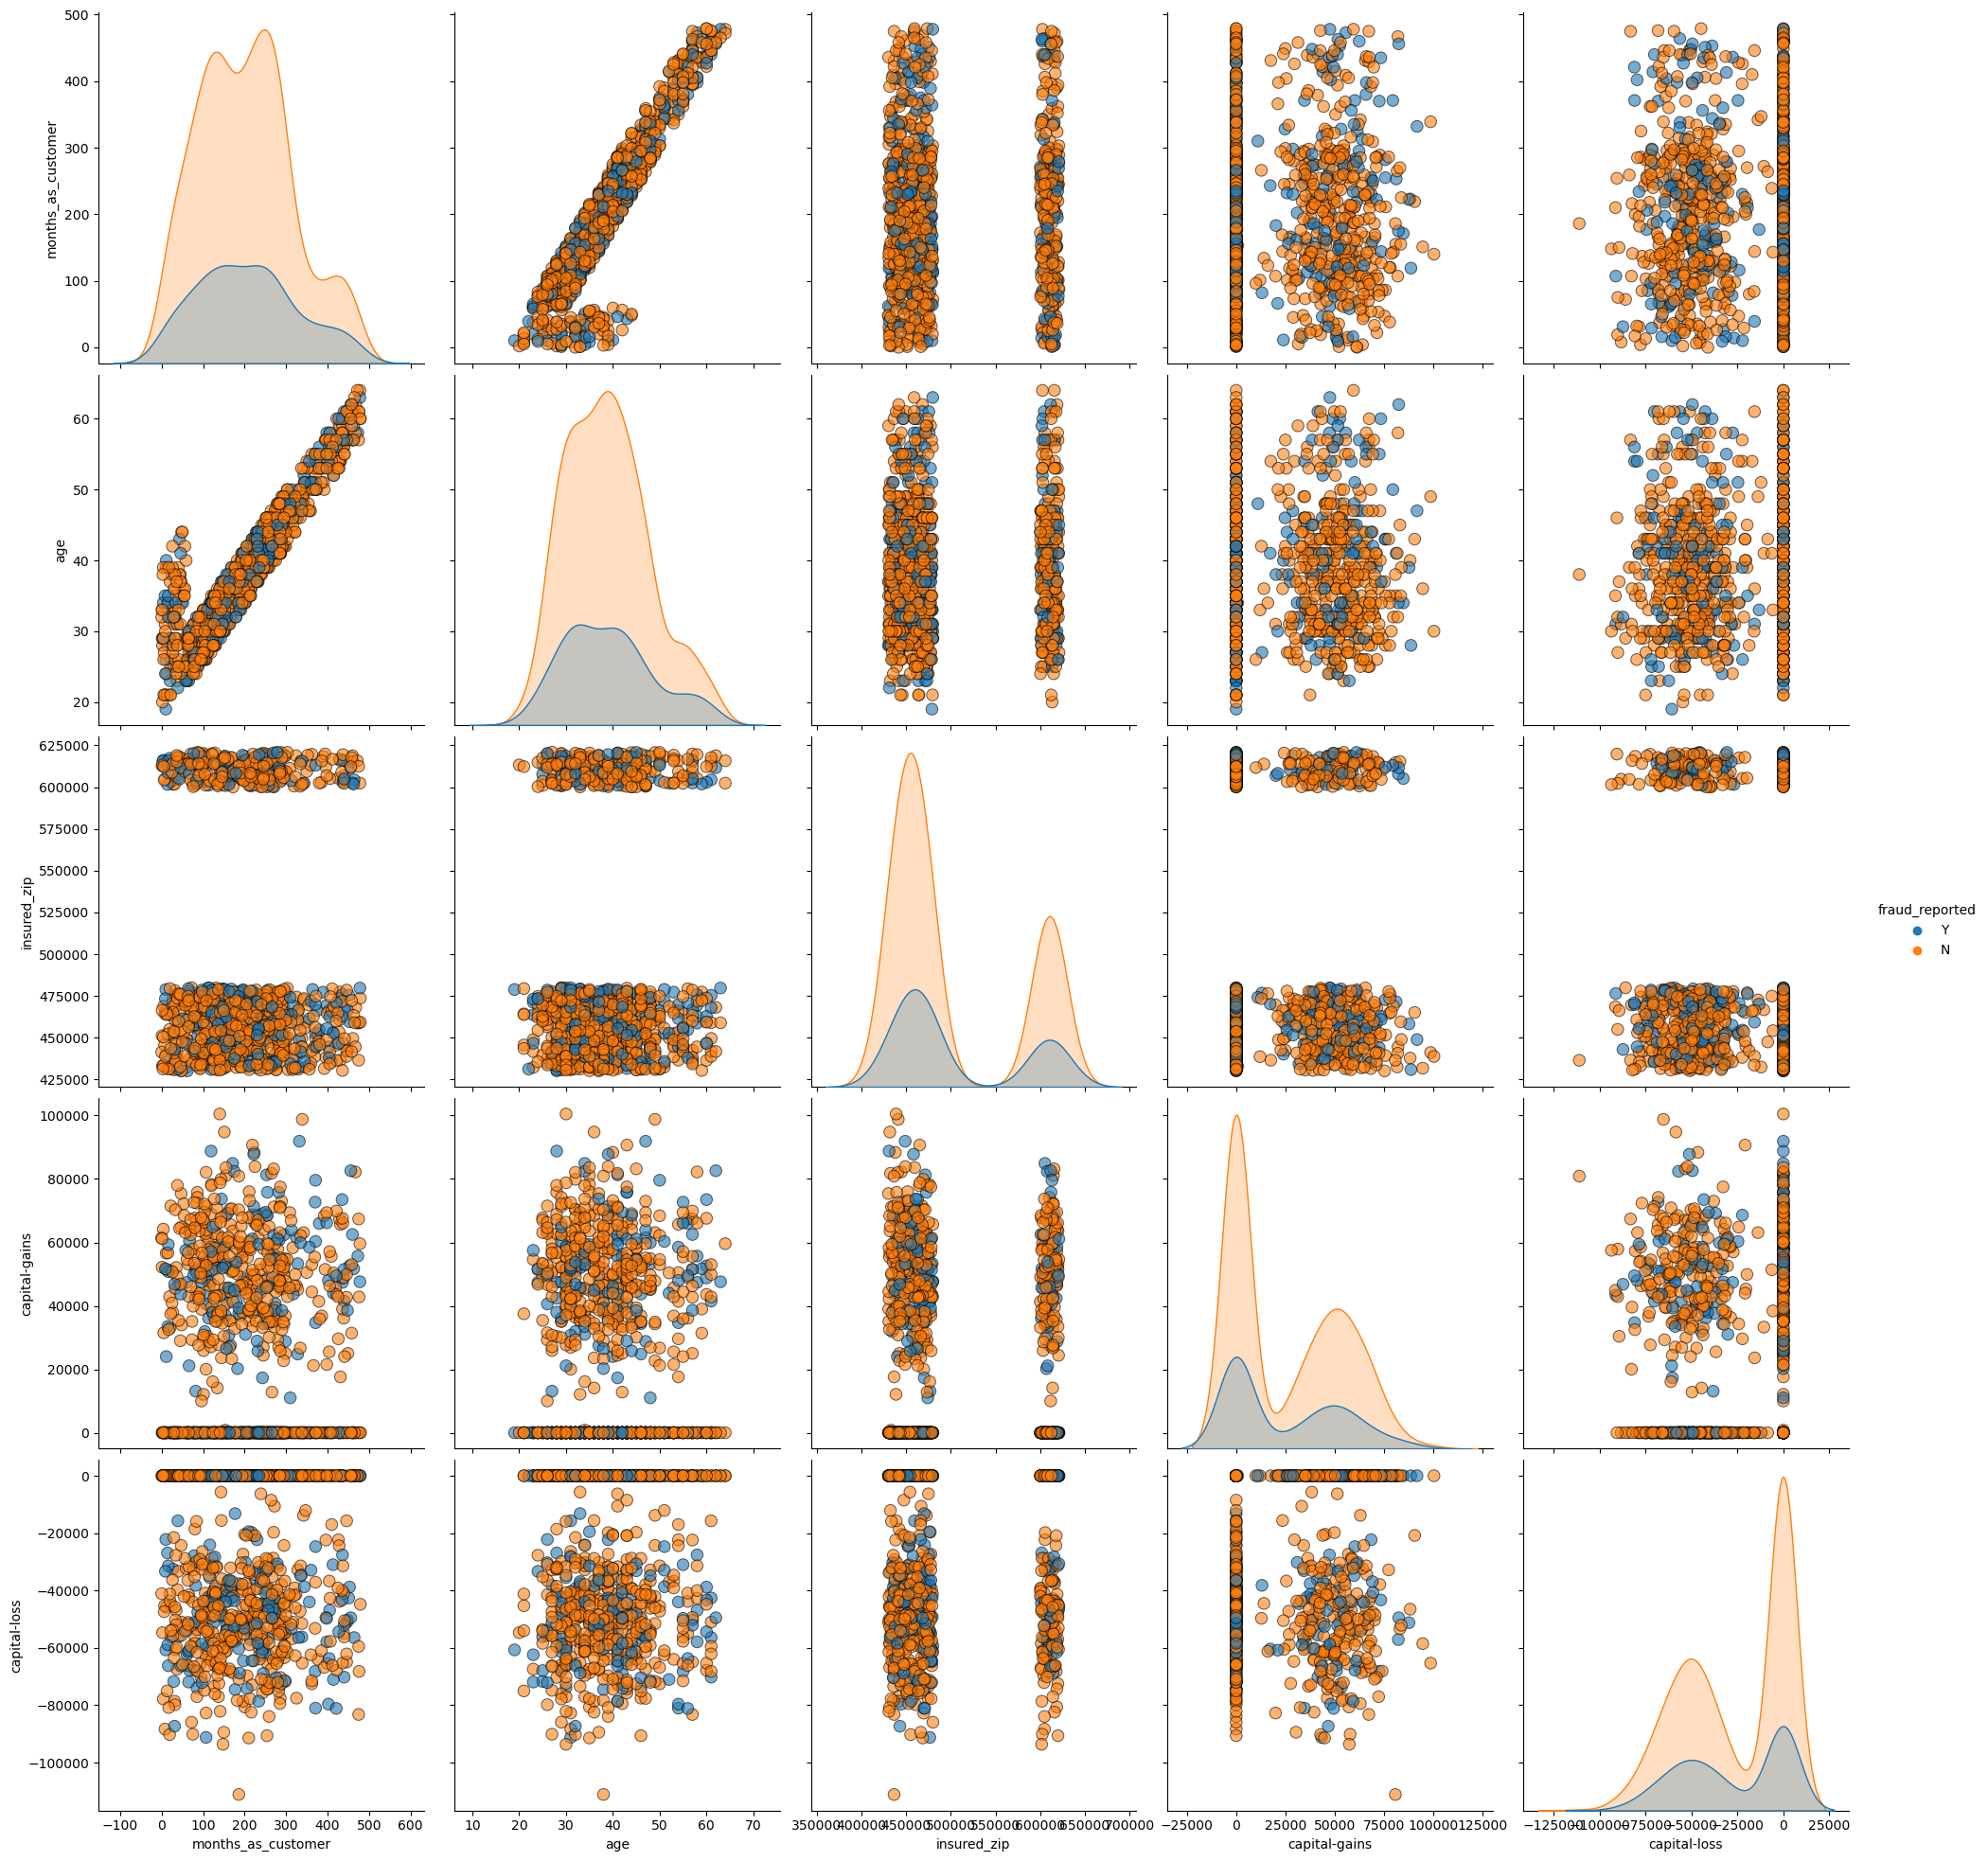

In [149]:
sns.pairplot(data=df, vars = ['months_as_customer', 'age', 'insured_zip', 'capital-gains', 'capital-loss'], hue="fraud_reported", diag_kind = 'kde', 
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             size = 4)
plt.show()

C:\Users\mauac\anaconda\lib\site-packages\seaborn\axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


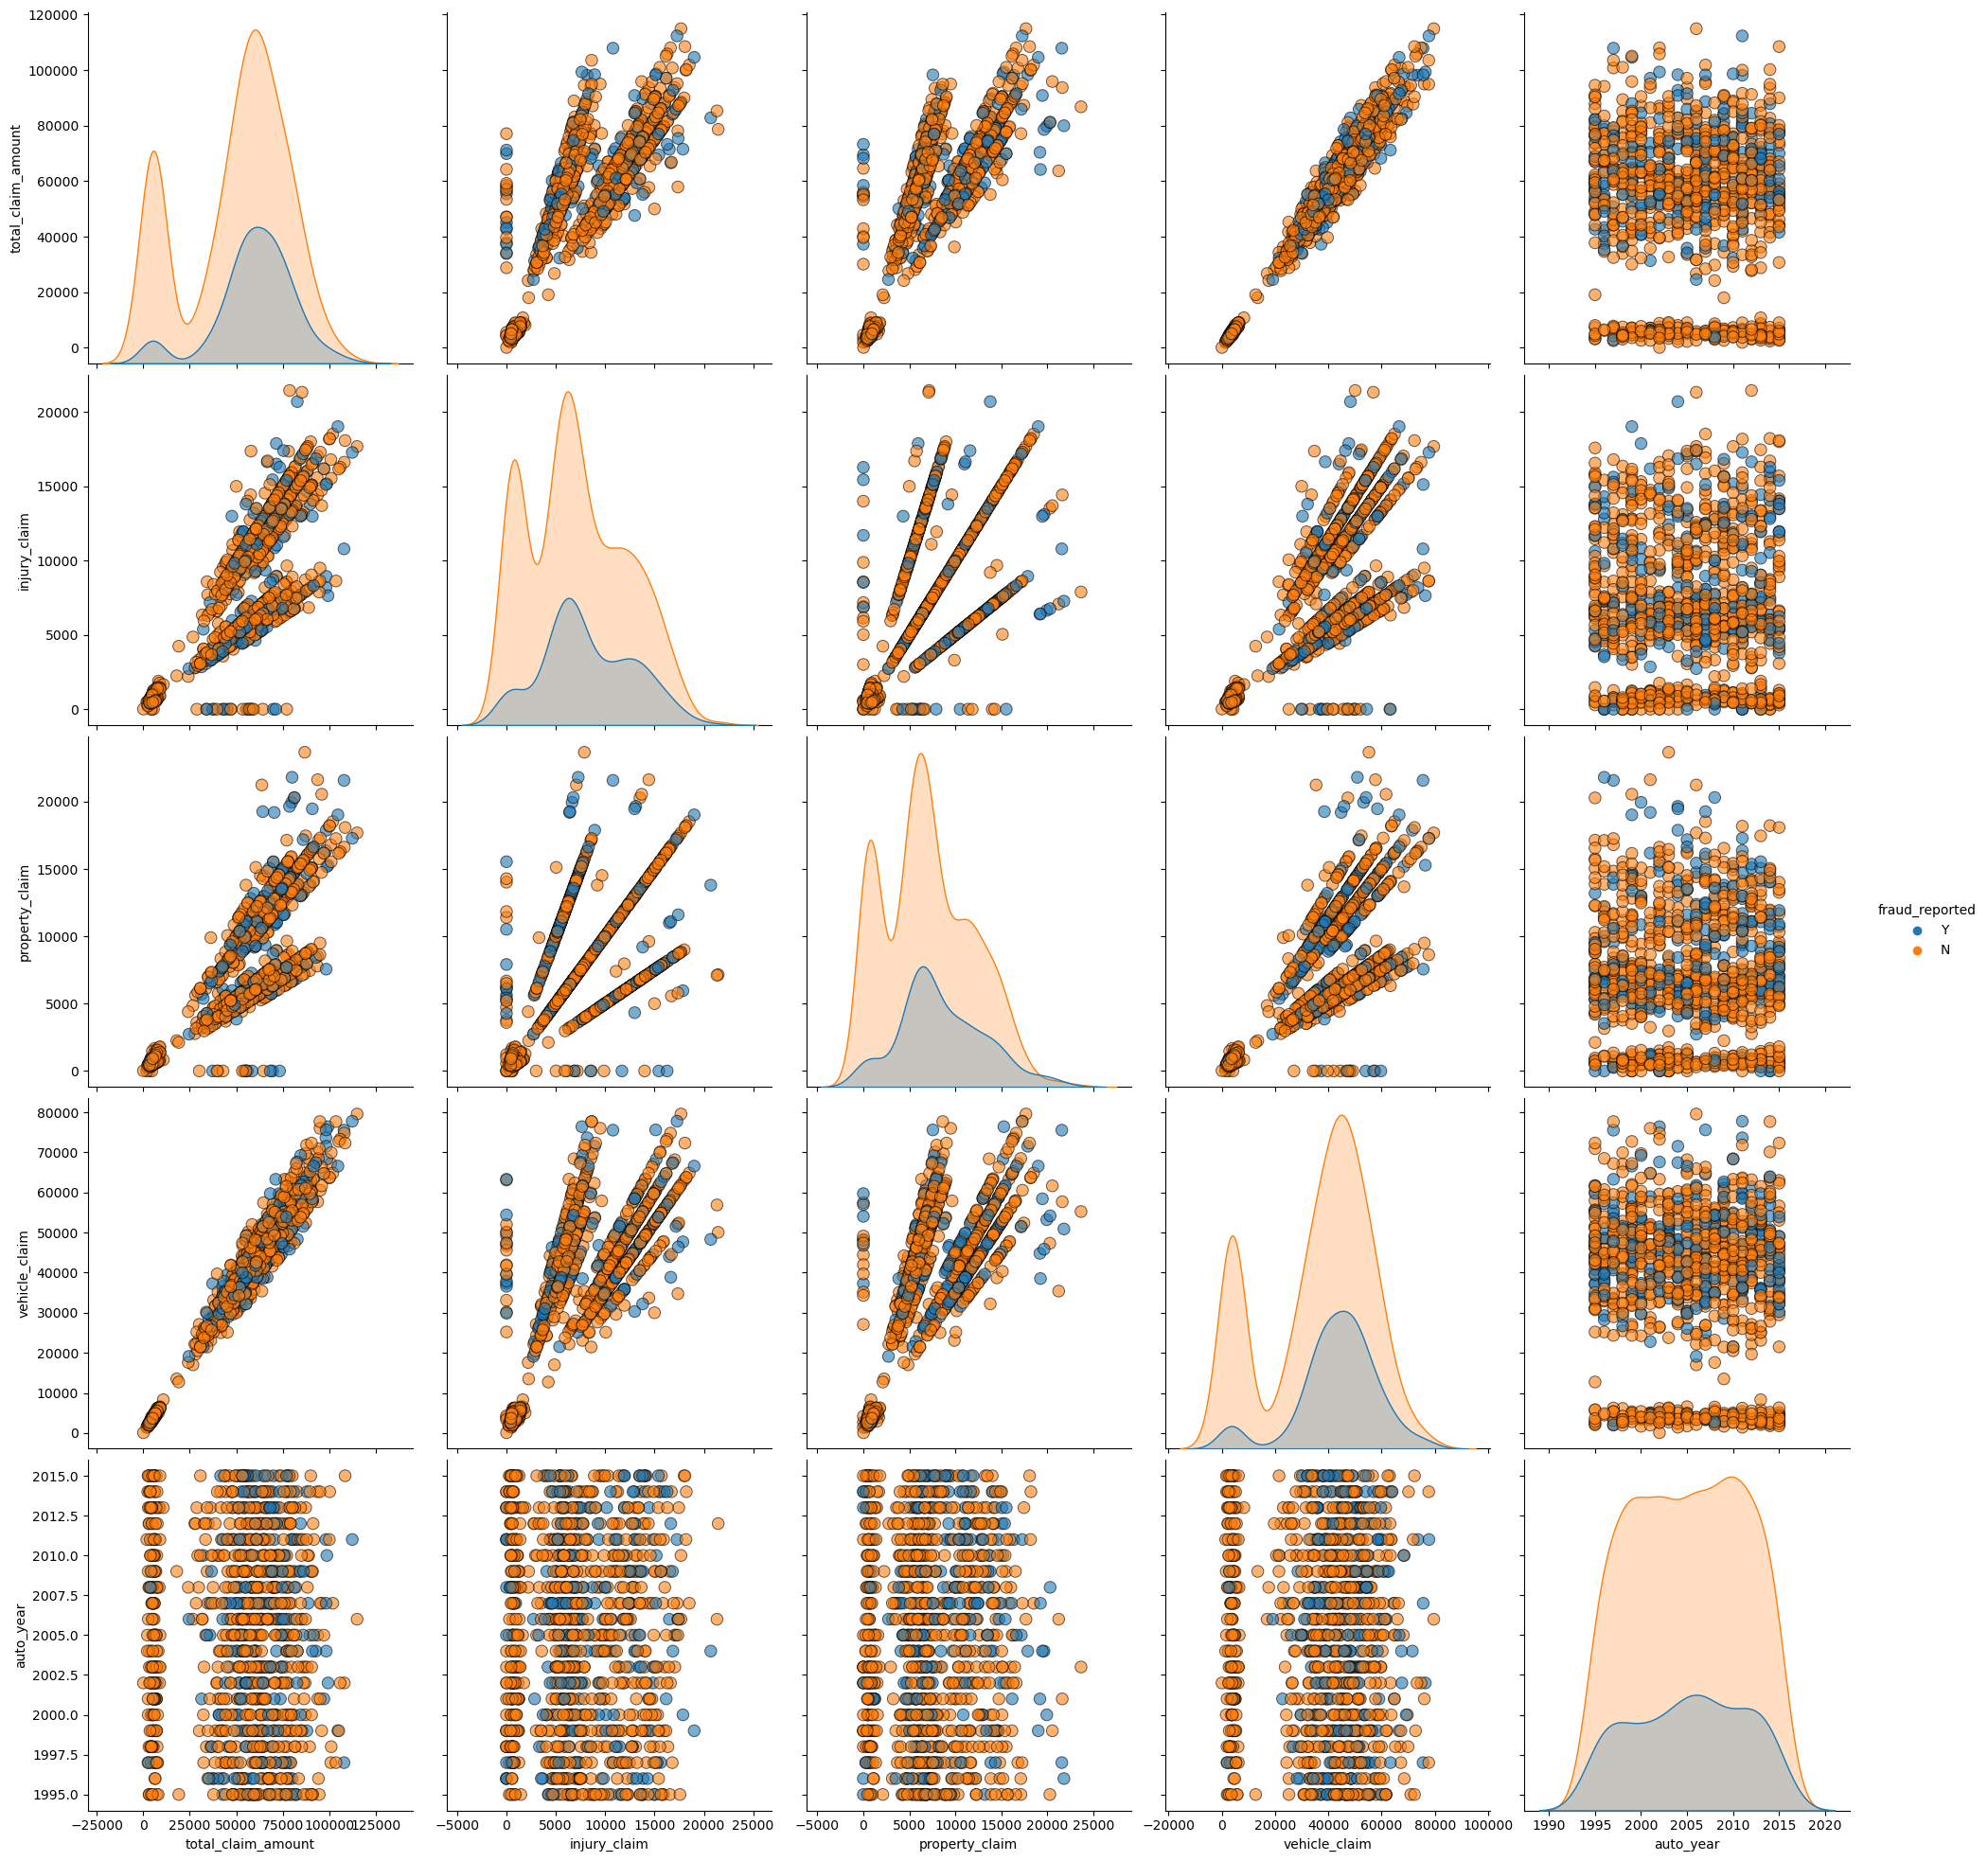

In [150]:
sns.pairplot(data=df, vars = ['total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim',
       'auto_year'], hue="fraud_reported", diag_kind = 'kde', 
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             size = 4)
plt.show()

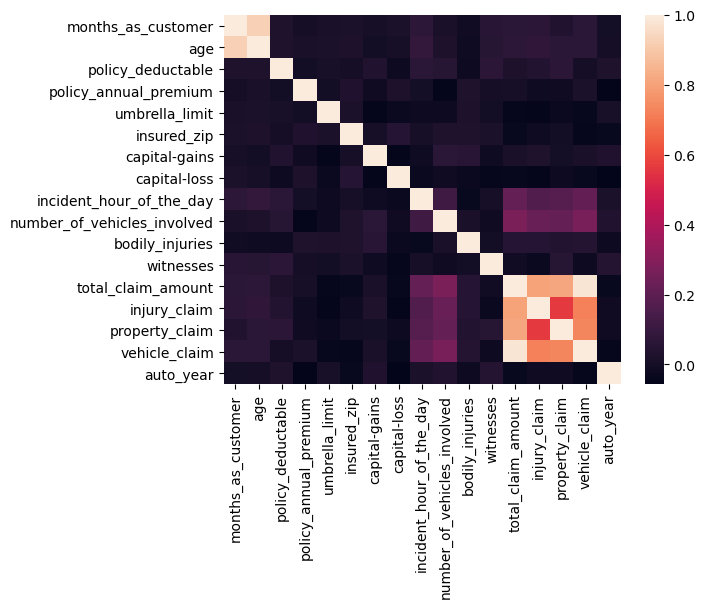

In [155]:
sns.heatmap(df.corr())
plt.show()

On voit qu'il y a un groupe des variables de notre df qui sont correlés

### Modélisation

#### Division de notre df en train et en set

In [210]:
X = df.drop(['fraud_reported'], axis= 1)
df['fraud_reported'] = np.array([(i == "Y") * 1 for i in df['fraud_reported']])
y = df['fraud_reported']

In [211]:
categorical_columns_X = X.select_dtypes(include = ['object']).columns

X_preprocessed = pd.get_dummies(X, columns=categorical_columns_X)
X_preprocessed.head()

months_as_customer  age  policy_deductable  policy_annual_premium  \
0                 328   48               1000                1406.91   
1                 228   42               2000                1197.22   
2                 134   29               2000                1413.14   
3                 256   41               2000                1415.74   
4                 228   44               1000                1583.91   

   umbrella_limit  insured_zip  capital-gains  capital-loss  \
0               0       466132          53300             0   
1         5000000       468176              0             0   
2         5000000       430632          35100             0   
3         6000000       608117          48900        -62400   
4         6000000       610706          66000        -46000   

   incident_hour_of_the_day  number_of_vehicles_involved  ...  \
0                         5                            1  ...   
1                         8                            1  ...   
2                         7                            3  ...   
3                         5                            1  ...   
4                        20                            1  ...   

   auto_make_Dodge  auto_make_Ford  auto_make_Honda  auto_make_Jeep  \
0                0               0                0               0   
1                0               0                0               0   
2                1               0                0               0   
3                0               0                0               0   
4                0               0                0               0   

   auto_make_Mercedes  auto_make_Nissan  auto_make_Saab  auto_make_Suburu  \
0                   0                 0               1                 0   
1                   1                 0               0                 0   
2                   0                 0               0                 0   
3                   0                 0               0                 0   
4                   0                 0               0                 0   

   auto_make_Toyota  auto_make_Volkswagen  
0                 0                     0  
1                 0                     0  
2                 0                     0  
3                 0                     0  
4                 0                     0  

[5 rows x 117 columns]

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, stratify = y)

In [213]:
sum(y) / len(y)

0.247

In [214]:
sum(y_train) / len(y_train)

0.24666666666666667

In [215]:
sum(y_test) / len(y_test)

0.248

#### Modèle

In [227]:
clf_xgb = xgb.XGBClassifier(objective="binary:logistic", seed = 2021)
clf_xgb.fit(X_train,
            y_train,
            verbose = True,
            early_stopping_rounds = 10,
            eval_metric = 'aucpr',
            eval_set = [(X_test, y_test)]
)

[0]	validation_0-aucpr:0.68406
[1]	validation_0-aucpr:0.70744
[2]	validation_0-aucpr:0.70184
[3]	validation_0-aucpr:0.72308
[4]	validation_0-aucpr:0.73216
[5]	validation_0-aucpr:0.71347
[6]	validation_0-aucpr:0.70710
[7]	validation_0-aucpr:0.70547
[8]	validation_0-aucpr:0.68974
[9]	validation_0-aucpr:0.69078


C:\Users\mauac\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-aucpr:0.72432
[11]	validation_0-aucpr:0.71066
[12]	validation_0-aucpr:0.71461
[13]	validation_0-aucpr:0.72076


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=2021,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2021,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

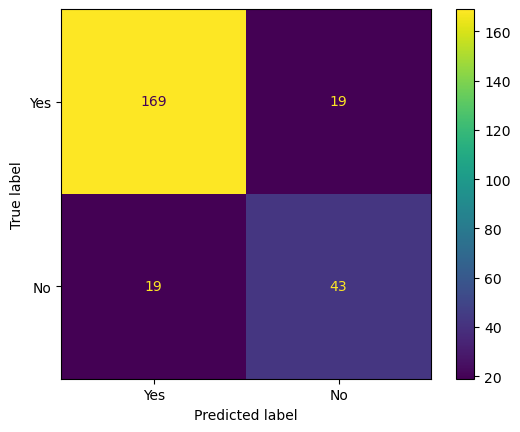

In [273]:
plot_confusion_matrix(clf_xgb,
                     X_test,
                     y_test,
                     values_format = 'd',
                     display_labels = ["Yes", "No"])
plt.show()

In [239]:
predictions = clf_xgb.predict(X_test) 
print(classification_report(y_test, predictions)) 

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       188
           1       0.69      0.69      0.69        62

    accuracy                           0.85       250
   macro avg       0.80      0.80      0.80       250
weighted avg       0.85      0.85      0.85       250



In [268]:
param_grid = {
                'max_depth': [4, 5, 6],  
                'learning_rate': [0.1, 0.01, 0.05], 
                'gamma':[5.0],
                'reg_lambda': [1.0, 10.0],
                'scale_pos_weight' : [3, 4, 5], # XGboost recommande sum(y==0)/ sum(y==1) = 5 dans df 
             } 

gs = GridSearchCV(xgb.XGBClassifier(objective="binary:logistic",seed = 2021), param_grid, cv = 5, scoring='roc_auc', verbose = 3,n_jobs=-1) 

In [269]:
# fitting the model for grid search 
gs.fit(X_train, y_train) 

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   45.1s finished
C:\Users\mauac\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:02:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     seed=2021, subsample=

In [270]:
# print best parameter after tuning 
print(gs.best_params_) 

{'gamma': 5.0, 'learning_rate': 0.01, 'max_depth': 4, 'reg_lambda': 1.0, 'scale_pos_weight': 4}


In [271]:
### Modèle finale:
clf_final_xgb = xgb.XGBClassifier(objective="binary:logistic",
                            seed=2021,  
                            gamma = 5.0,
                            learning_rate = 0.01, 
                            max_depth = 4, 
                            reg_lambda = 1.0,
                            scale_pos_weight = 4
)
clf_final_xgb.fit(X_train,
            y_train,
            verbose = True,
            early_stopping_rounds = 10,
            eval_metric = 'aucpr',
            eval_set = [(X_test, y_test)]
)


[0]	validation_0-aucpr:0.70915
[1]	validation_0-aucpr:0.70915
[2]	validation_0-aucpr:0.71278
[3]	validation_0-aucpr:0.70963
[4]	validation_0-aucpr:0.71278
[5]	validation_0-aucpr:0.71278
[6]	validation_0-aucpr:0.71278
[7]	validation_0-aucpr:0.71363
[8]	validation_0-aucpr:0.71363
[9]	validation_0-aucpr:0.71363
[10]	validation_0-aucpr:0.71459
[11]	validation_0-aucpr:0.71363
[12]	validation_0-aucpr:0.71459


C:\Users\mauac\anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-aucpr:0.72055
[14]	validation_0-aucpr:0.71967
[15]	validation_0-aucpr:0.72055
[16]	validation_0-aucpr:0.72055
[17]	validation_0-aucpr:0.72055
[18]	validation_0-aucpr:0.72055
[19]	validation_0-aucpr:0.72196
[20]	validation_0-aucpr:0.72142
[21]	validation_0-aucpr:0.72280
[22]	validation_0-aucpr:0.73524
[23]	validation_0-aucpr:0.73439
[24]	validation_0-aucpr:0.73777
[25]	validation_0-aucpr:0.73777
[26]	validation_0-aucpr:0.73742
[27]	validation_0-aucpr:0.76577
[28]	validation_0-aucpr:0.76509
[29]	validation_0-aucpr:0.76594
[30]	validation_0-aucpr:0.76594
[31]	validation_0-aucpr:0.76594
[32]	validation_0-aucpr:0.76594
[33]	validation_0-aucpr:0.76609
[34]	validation_0-aucpr:0.76609
[35]	validation_0-aucpr:0.76624
[36]	validation_0-aucpr:0.76609
[37]	validation_0-aucpr:0.76624
[38]	validation_0-aucpr:0.76286
[39]	validation_0-aucpr:0.76255
[40]	validation_0-aucpr:0.76326
[41]	validation_0-aucpr:0.76258
[42]	validation_0-aucpr:0.76258
[43]	validation_0-aucpr:0.76258
[44]	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=5.0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=2021,
              reg_alpha=0, reg_lambda=1.0, scale_pos_weight=4, seed=2021,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

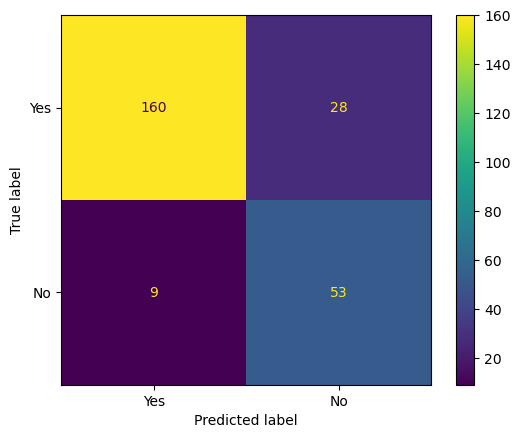

In [272]:
plot_confusion_matrix(clf_final_xgb,
                     X_test,
                     y_test,
                     values_format = 'd',
                     display_labels = ["Yes", "No"])
plt.show()

In [274]:
predictions = clf_xgb.predict(X_test) 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       188
           1       0.69      0.69      0.69        62

    accuracy                           0.85       250
   macro avg       0.80      0.80      0.80       250
weighted avg       0.85      0.85      0.85       250



In [281]:
roc_auc_score(y_test, predictions)

0.79624227865477